In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import Recall, Precision

import json
import matplotlib.pyplot as plt

# Prepare the dataset

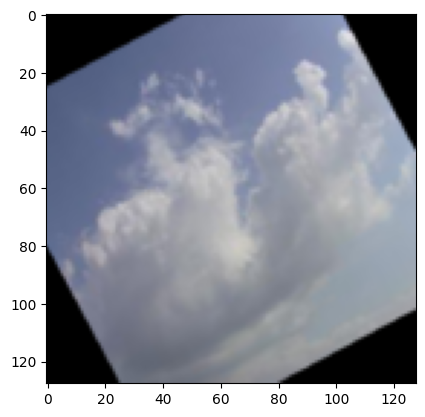

In [34]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "data/clouds/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image[0].squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()

test_transforms = transforms.Compose([    
                                      transforms.ToTensor(),    
                                      transforms.Resize((128, 128)),])
dataset_test = ImageFolder("data/clouds/clouds_test",   transform=test_transforms,)

dataloader_test = DataLoader(
      dataset_test,
      batch_size=1,
      shuffle=False,
      drop_last=False,
)


# Implement a CNN

In [27]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            # nn.Flatten(),
        )
        
        # Calculate the expected size of the flattened tensor
        self.feature_size = self._get_feature_size((3, 128, 128))
        # Define classifier using calculated feature_size
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
    def _get_feature_size(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [28]:
# Define the model
net = Net(7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 2.6946
Epoch 2, Loss: 1.6491
Epoch 3, Loss: 1.4474


In [35]:
# Define metrics
metric_precision = Precision(task='multiclass', num_classes=7, average='micro')
metric_recall = Recall(task='multiclass', num_classes=7, average='micro')

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.5411522388458252
Recall: 0.5411522388458252


In [39]:
# Define precision metric
metric_precision = Precision(
    task='multiclass', num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
display(precision_per_class)

{'cirriform clouds': 0.5945945978164673,
 'clear sky': 0.7325581312179565,
 'cumulonimbus clouds': 0.7777777910232544,
 'cumulus clouds': 0.6804123520851135,
 'high cumuliform clouds': 0.36666667461395264,
 'stratiform clouds': 1.0,
 'stratocumulus clouds': 0.0}